# 소프트웨어 최신기술 과제 (임세준 교수님)
# 20181639 안상호 

### import
일반적으로 코드에 필요한 라이브러리 import는 파일의 가장 상단에서 실행, 하지만 실습 설명상 필요한 곳에서 import 함

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.2


# **Lane Line Binary Segmentation 실습**

In [2]:
!wget lane_detection_dataset.zip https://www.dropbox.com/s/a3pvo5rukig1l5s/lane_detection_dataset.zip

--2022-11-26 07:02:01--  http://lane_detection_dataset.zip/
Resolving lane_detection_dataset.zip (lane_detection_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘lane_detection_dataset.zip’
--2022-11-26 07:02:01--  https://www.dropbox.com/s/a3pvo5rukig1l5s/lane_detection_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/a3pvo5rukig1l5s/lane_detection_dataset.zip [following]
--2022-11-26 07:02:02--  https://www.dropbox.com/s/raw/a3pvo5rukig1l5s/lane_detection_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0cc97e75434a2d4a574e428adf.dl.dropboxusercontent.com/cd/0/inline/Bxfudgx3_FaWQ6qoEBSLsCtHHu4jgDXEvYk5dVLCkIqWsSV3468fUZunllFfOLjoGv8xLgQUREB-7upLO9Jnl1dUWRYWtrMayy

In [3]:
import os

try:
     os.makedirs('/content/LaneDetection')
except:
  pass

os.chdir('/content/LaneDetection')
try:
    os.makedirs('data')
except:
    pass

In [4]:
!unzip -q /content/lane_detection_dataset.zip -d /content/LaneDetection/data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 100

# ImageDataGenerator를 활용해 Train, Validation, Test용 데이터 불러오기

train_data_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory('./data/TrainData', batch_size = 8, target_size = (256,512), seed = SEED,class_mode = None)

train_label_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory('./data/TrainLabel', batch_size = 8, target_size = (256,512), seed = SEED,class_mode = None)

valid_data_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory('./data/ValidData', batch_size = 8, target_size = (256,512), seed = SEED,class_mode = None)

valid_label_generator = ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory('./data/ValidLabel', batch_size = 8, target_size = (256,512), seed = SEED,class_mode = None)



Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


# U-net model생성하기

In [6]:
from tensorflow import keras 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, UpSampling2D, Activation, Add

# 입력 shape 256, 512, 3
input = Input(shape = (256,512,3)) 

# input 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 32채널
# conv1을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지
# MaxPool을 통해 shape 1/2로 감소 
# 128 256 32
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(input)
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

# conv1 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 64채널
# conv2을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지
# MaxPool을 통해 shape 1/2로 감소 
# 64 128 64
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool1)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

# conv2 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 128채널
# conv3을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지
# MaxPool을 통해 shape 1/2로 감소 
# 32 64 128
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool2)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

# conv3 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 256채널
# conv4을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지
# MaxPool을 통해 shape 1/2로 감소 
# 16 32 256
conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool3)
conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

# conv4 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 512채널
# conv5을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지
# up_conv1을 통과하여 shape이 2배 증가 이때 shape은 32 64 256
conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool4)
conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv5)
up_conv1 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv5))

# 다음 conv layer에 넘길 conv4,up_conv1을 더함.
merge_data1 = Add()([conv4,up_conv1])

# merge_data1 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 256채널
# conv6을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지
# up_conv2을 통과하여 shape이 2배 증가 이때 shape은 64 128 128
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge_data1)
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv6)
up_conv2 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))

# 다음 conv layer에 넘길 conv3,up_conv2을 더함.
merge_data2 = Add()([conv3,up_conv2])

# merge_data2 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 128채널
# conv7을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지
# up_conv3을 통과하여 shape이 2배 증가 이때 shape은 128 256 64
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge_data2)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv7)
up_conv3 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))

# 다음 conv layer에 넘길 conv2,up_conv3을 더함.
merge_data3 = Add()([conv2,up_conv3])

# merge_data3 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 64채널
# conv8을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지
# up_conv4을 통과하여 shape이 2배 증가 이때 shape은 256 512 32
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge_data3)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv8)
up_conv4 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))

# 다음 conv layer에 넘길 conv1,up_conv4을 더함.
merge_data4 = Add()([conv1,up_conv4])

# merge_data4 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 32채널
# conv9 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 32채널
# conv9 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 2채널
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge_data4)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)

# ouptput값으로 1by1 convolution을 통과후 sigmoid 를 통과한 값으로 정의
predictions = Conv2D(1, 1, activation = 'sigmoid')(conv9)
# U-net model 생성
U_net = Model(inputs = input, outputs = predictions)

### Encoder Decoder 구조 사용하여 Segnet 구조와 유사한 LaneNet 모델 생성

In [7]:
from tensorflow import keras 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, UpSampling2D, Activation, Add

input = Input(shape = (256,512,3)) 

################# Encoder1 ####################
# input 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 32채널
# enc1을 BatchNormalization통한 안정화 과정 진행
# 위와 같은 과정을 2번 실행 , 이때 입력값은 enc1
# 그 후  Maxpooling을 통한 입력 사이즈를 반으로 줄인다.
# MAxpooling을 하는 이유는 parameter 수가 줄어 들여 오버피팅 방지와 연산량(하드웨어 에너지) 감소 등이 있다.
# 그 후 conv layer를 거치고 BatchNormalization통한 안정화 과정 진행
# Encoder1 거치고나서의 shape 128  256  32 이다.

# 코드 작성
enc1 = Conv2D(32,3 , padding = 'same', activation = 'relu')(input) 
enc1 = BatchNormalization()(enc1) 
enc1 = Conv2D(32,3 , padding = 'same', activation = 'relu')(enc1) 
enc1 = BatchNormalization()(enc1) 
enc1 = MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same')(enc1) 
enc1 = Conv2D(32,3 , padding = 'same', activation = 'relu')(enc1)
enc1 = BatchNormalization()(enc1) # 128 * 256 * 32
################################################

################# Encoder2 ####################
# enc1 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 64채널
# enc2을 BatchNormalization통한 안정화 과정 진행
# 위와 같은 과정을 2번 실행 , 이때 입력값은 enc1
# 그 후  Maxpooling을 통한 입력 사이즈를 반으로 줄인다.(pool_size = (2,2), strides = (2,2), padding = 'same')
# MAxpooling을 하는 이유는 parameter 수가 줄어 들여 오버피팅 방지와 연산량(하드웨어 에너지) 감소 등이 있다.
# 그 후 conv layer를 거치고 BatchNormalization통한 안정화 과정 진행
# Encoder1 거치고나서의 shape 64  128  64 이다.

# 코드 작성
enc2 = Conv2D(64,3 , padding = 'same', activation = 'relu')(enc1)
enc2 = BatchNormalization()(enc2)
enc2 = Conv2D(64,3 , padding = 'same', activation = 'relu')(enc2)
enc2 = BatchNormalization()(enc2)
enc2 = MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same')(enc2)
enc2 = Conv2D(64,3 , padding = 'same', activation = 'relu')(enc2)
enc2 = BatchNormalization()(enc2) # 64 128 64

################################################

################# Residual1 ####################
# enc2 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 128채널
# res1을 BatchNormalization통한 안정화 과정 진행
# res1 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 64채널
# res1을 BatchNormalization통한 안정화 과정 진행
# residual 과정으로 res1,enc2를 합쳐 relu를 거친다
# residual부분을 사용하는 이유는 기울기 소실문제를 해결이 가능하다.
# 이때 shape는 64 128  64 로 위와 동일하다 

# 코드 작성
res1 = Conv2D(128,3 , padding = 'same', activation = 'relu')(enc2)
res1 = BatchNormalization()(res1)
res1 = Conv2D(64,3 , padding = 'same', activation = 'relu')(res1)
res1 = BatchNormalization()(res1)
merge_data = Add()([res1,enc2])
res1 = Activation('relu')(merge_data) # 64 128 64

################################################

################# Residual2 ####################
# res1 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 128채널
# res2을 BatchNormalization통한 안정화 과정 진행
# res2 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 64채널
# res2을 BatchNormalization통한 안정화 과정 진행
# residual 과정으로 res2,res1를 합쳐 relu를 거친다
# residual부분을 사용하는 이유는 기울기 소실문제를 해결이 가능하다.
# 이때 shape는 64 128  64 로 위와 동일하다 

# 코드 작성
res2 = Conv2D(128,3 , padding = 'same', activation = 'relu')(res1)
res2 = BatchNormalization()(res2)
res2 = Conv2D(64,3 , padding = 'same', activation = 'relu')(res2)
res2 = BatchNormalization()(res2)
merge_data = Add()([res2,res1])
res2 = Activation('relu')(merge_data) # 64 128 64

################################################

################# Decoder1 ####################
# res1 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 32채널
# dec1을 BatchNormalization통한 안정화 과정 진행
# 위와 같은 과정을 2번 실행 , 이때 입력값은 dec1
# UpSampling2D을통해 shape을 두배로 만든다.
# 그 후 conv layer를 거치고 BatchNormalization통한 안정화 과정 진행
# 이때 shape는 2배가 늘어나 128 256 32 이다

# 코드 작성
dec1 = Conv2D(32,3 , padding = 'same', activation = 'relu')(res2)
dec1 = BatchNormalization()(dec1)
dec1 = Conv2D(32,3 , padding = 'same', activation = 'relu')(dec1)
dec1 = BatchNormalization()(dec1)
dec1 = UpSampling2D(size = (2,2))(dec1)
dec1 = Conv2D(32,3 , padding = 'same', activation = 'relu')(dec1)
dec1 = BatchNormalization()(dec1) #  128 256 32

################################################

################# Decoder2 ####################
# dec1 을 받아 Conv2D layer relu통과 이때 padding = same을 하여 크기 유지, 1채널
# dec2을 BatchNormalization통한 안정화 과정 진행
# 위와 같은 과정을 2번 실행 , 이때 입력값은 dec2
# UpSampling2D을통해 shape을 두배로 만든다.
# 그 후 conv layer를 거치고 BatchNormalization통한 안정화 과정 진행
# 이때 shape는 2배가 늘어나 256 512 1 이다.
# 그후 predictions값으로 simoid를 거쳐 반환한다.

# 코드 작성
dec2 = Conv2D(1,3 , padding = 'same', activation = 'relu')(dec1)
dec2 = BatchNormalization()(dec2)
dec2 = Conv2D(1,3 , padding = 'same', activation = 'relu')(dec2)
dec2 = BatchNormalization()(dec2)
dec2 = UpSampling2D(size = (2,2))(dec2)
dec2 = Conv2D(1,3 , padding = 'same', activation = 'relu')(dec2)
dec2 = BatchNormalization()(dec2) #  256 512 1
predictions = Activation('sigmoid')(dec2)
# predictions = Activation('sigmoid')(dec2) # 256*512*1

# LaneNet 모델 생성
LaneNet = Model(inputs = input, outputs = predictions)

In [8]:
from tensorflow.keras.optimizers import Adam

# optimizer로 Adam(learning_rate = 1e-4)를 사용하고 , binary_crossentropy loss function을 사용.
U_net .compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
U_net .summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [9]:
# optimizer로 Adam(learning_rate = 1e-4)를 사용하고 , binary_crossentropy loss function을 사용.
LaneNet.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
LaneNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 512, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 512, 32  128        ['conv2d_24[0][0]']              
 alization)                     )                                                           

In [10]:
batch_size = 8
steps_per_epoch = 4000 // batch_size
validation_batch_size = 8
validation_steps = 1000// batch_size

# U_net  학습
print("U-net")
U_net_history = U_net.fit(zip(train_data_generator, train_label_generator), validation_data=zip(valid_data_generator, valid_label_generator), epochs = 5, batch_size = batch_size, steps_per_epoch = steps_per_epoch,
                    validation_batch_size = validation_batch_size, validation_steps = validation_steps) # batch size 실험 하기

print("==================================================================================")
LaneNet_history = LaneNet.fit(zip(train_data_generator, train_label_generator), validation_data=zip(valid_data_generator, valid_label_generator), epochs = 5, batch_size = batch_size, steps_per_epoch = steps_per_epoch,
                    validation_batch_size = validation_batch_size, validation_steps = validation_steps) # batch size 실험 하기


U-net
Epoch 1/5
500/500 [==============================] - 232s 441ms/step - loss: 0.1511 - accuracy: 0.9330 - val_loss: 0.0760 - val_accuracy: 0.9325
Epoch 2/5
500/500 [==============================] - 222s 444ms/step - loss: 0.0544 - accuracy: 0.9392 - val_loss: 0.0450 - val_accuracy: 0.9484
Epoch 3/5
500/500 [==============================] - 222s 444ms/step - loss: 0.0377 - accuracy: 0.9493 - val_loss: 0.0259 - val_accuracy: 0.9502
Epoch 4/5
500/500 [==============================] - 222s 445ms/step - loss: 0.0240 - accuracy: 0.9506 - val_loss: 0.0228 - val_accuracy: 0.9504
Epoch 5/5
500/500 [==============================] - 222s 445ms/step - loss: 0.0225 - accuracy: 0.9509 - val_loss: 0.0236 - val_accuracy: 0.9506
Epoch 1/5
500/500 [==============================] - 82s 157ms/step - loss: 0.6354 - accuracy: 0.8883 - val_loss: 0.6039 - val_accuracy: 0.9282
Epoch 2/5
500/500 [==============================] - 81s 163ms/step - loss: 0.5844 - accuracy: 0.9372 - val_loss: 0.5659 - va

In [25]:
# Test data를 활용해 모델 성능 살펴보기

test_data_generator= ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory('./data/TestData', batch_size = 8, target_size = (256,512), seed = SEED,class_mode = None)

test_label_generator= ImageDataGenerator(rescale = 1.0/255.0).flow_from_directory('./data/TestLabel', batch_size = 8, target_size = (256,512), seed = SEED,class_mode = None)


X = next(iter(test_data_generator))
Y = next(iter(test_label_generator))
Y_pred = U_net.predict(X)
Y_pred = tf.round(Y_pred) # Threshold = 0.5

Y_pred2 = LaneNet.predict(X)
Y_pred2 = tf.round(Y_pred2) # Threshold = 0.5

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
1/1 [==============================] - 0s 23ms/step


실제 이미지


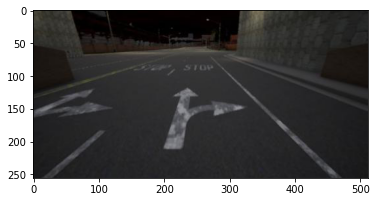

U_net 예측 이미지


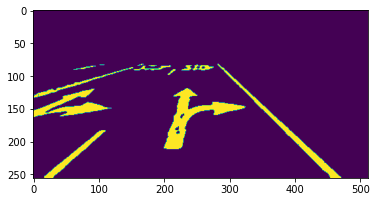

LaneNet 예측 이미지


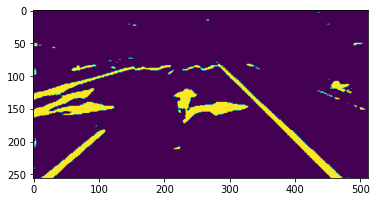

y 이미지


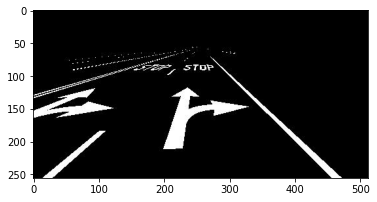

실제 이미지


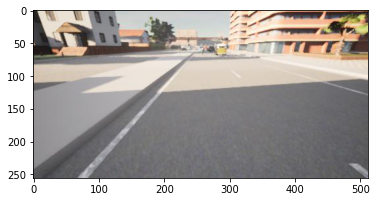

U_net 예측 이미지


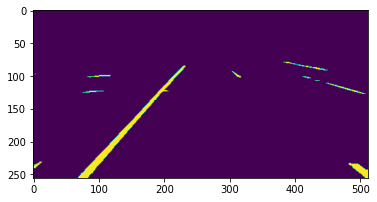

LaneNet 예측 이미지


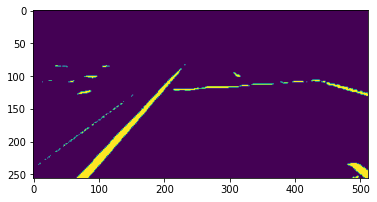

y 이미지


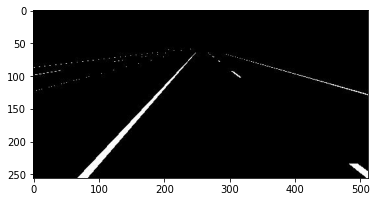

실제 이미지


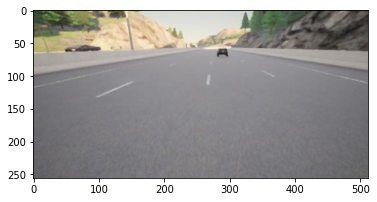

U_net 예측 이미지


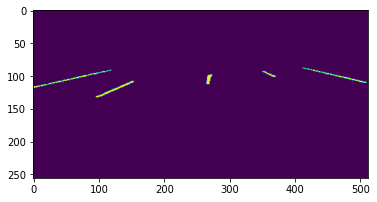

LaneNet 예측 이미지


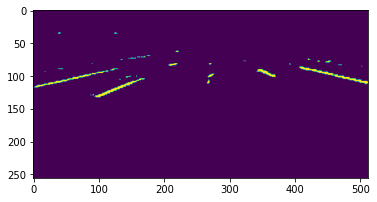

y 이미지


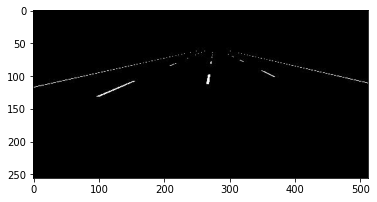

실제 이미지


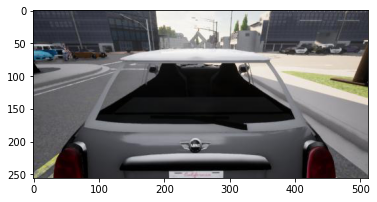

U_net 예측 이미지


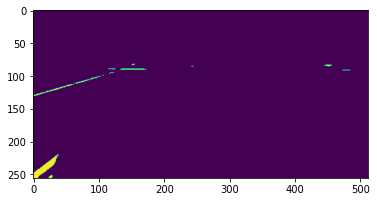

LaneNet 예측 이미지


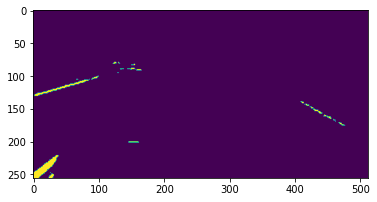

y 이미지


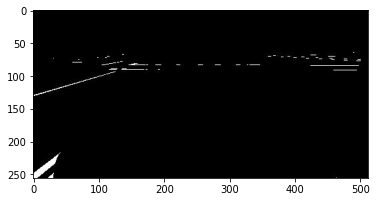

실제 이미지


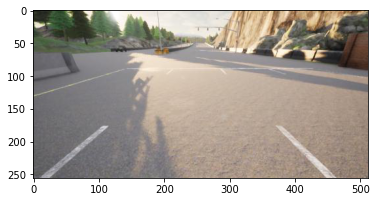

U_net 예측 이미지


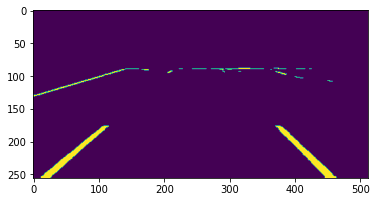

LaneNet 예측 이미지


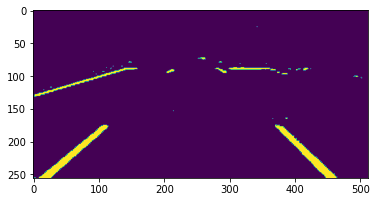

y 이미지


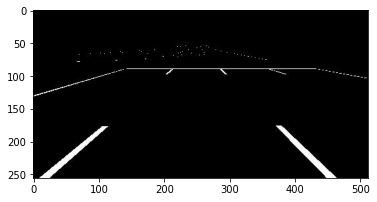

실제 이미지


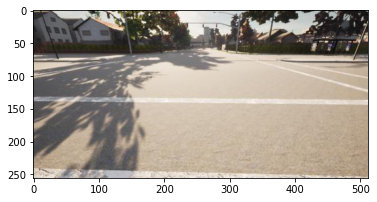

U_net 예측 이미지


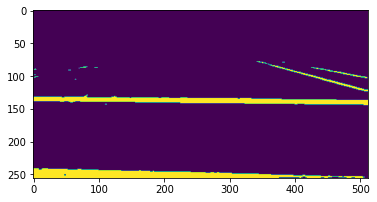

LaneNet 예측 이미지


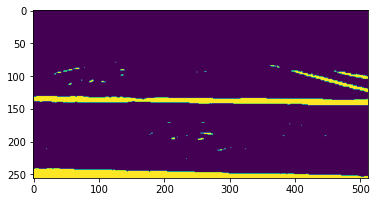

y 이미지


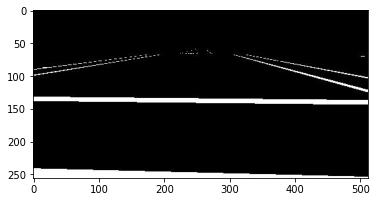

실제 이미지


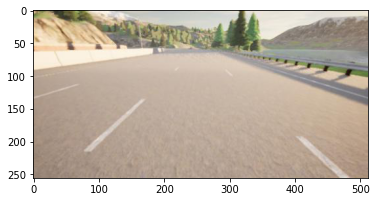

U_net 예측 이미지


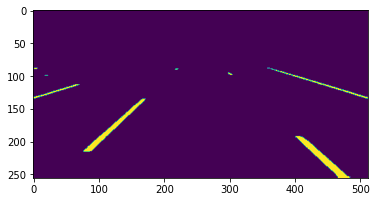

LaneNet 예측 이미지


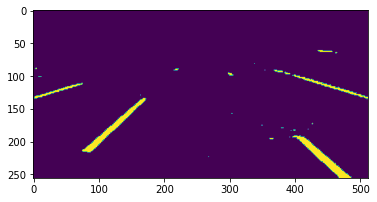

y 이미지


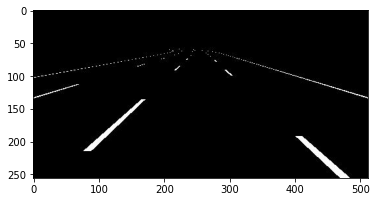

실제 이미지


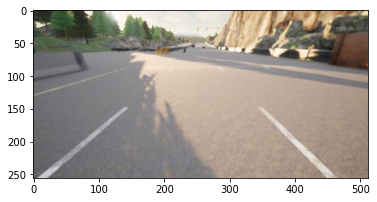

U_net 예측 이미지


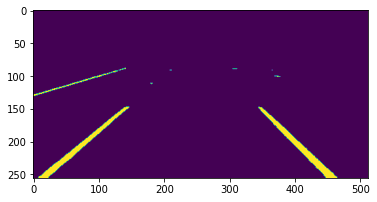

LaneNet 예측 이미지


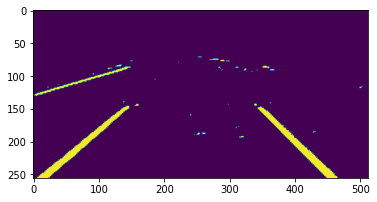

y 이미지


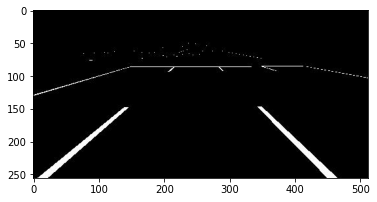

In [26]:
# 첫배치에대한 이미지와 예측, y 이미지 출력
import matplotlib.pyplot as plt
for i in range(8):
    print("실제 이미지")
    plt.imshow(X[i])
    plt.show()

    print("U_net 예측 이미지")
    plt.imshow(Y_pred[i][:,:,0])
    plt.show()

    print("LaneNet 예측 이미지")
    plt.imshow(Y_pred2[i][:,:,0])
    plt.show()

    print("y 이미지")
    plt.imshow(Y[i])
    plt.show()
    print("======================================")